# Estructuración y Modelación de indicadores técnicos

Este libro contiene el codigo que se empleo para la estructuración y la modelación de los indicadores técnicos. La modelación se realiza mediante la librería `Ta-Lib` y se construyeron funciones que permiten flexibilidad de utilizar diferentes ventanas de tiempo para el  estudio. 

Si desea consultar mas información del uso de la librería `Ta-Lib` y sus alcances puede visitar las siguientes paginas web:

* https://github.com/mrjbq7/ta-lib
* https://mrjbq7.github.io/ta-lib/doc_index.html
* https://pypi.org/project/TA-Lib/



Los estudiantes que participaron en el desarrollo de este proyecto son:

1. Santiago Echeverri Calderon - sechev11@eafit.edu.co
2. Edgar Leandro Jimenez - eljimenezj@eafit.edu.co
3. Jorge Luis Renteria - jlrenteria@eafit.edu.co
4. Luis Rodgrigo Vesga - lrvesga@eafit.edu.co
5. Alvaro Villa - avillav2@eafit.edu.co

Universidad Eafit, 2020.

El notebook está organizado de la siguiente manera

1. Introducción
2. Definición de funciones de lectura y cálculos de indicadores técnicos
3. Lectura de datos y análisis exploratorio de datos
4. Modelación y optimización utilizando machine learning
5. Resultados gráficos e instancia del mejor modelo
6. Reducción de la dimensionalidad y entrenamiento con mejor modelo
7. Backtesting simple

# 1.  Introducción

En la última década, los sistemas transaccionales del mercado de capitales han permitido que se generen una gran cantidad de datos financieros que han crecido de una forma sin precedentes. Este rápido crecimiento del volumen de datos representa un reto para analizarlos e interpretarlos.  Con el presente proyecto se busca desarrollar un enfoque automatizado para un análisis eficiente de estos datos financieros, que involucran información del análisis técnico y el análisis fundamental como insumo para un modelo de Machine Learning.  La predicción de decisiones se articulará como un problema de clasificación que proporcione recomendaciones sobre el comportamiento positivo o negativo de una divisa en el futuro.

In [0]:
# Vamos a cargar las Librerias necesarias para preprocesar
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from PIL import Image
import pandas as pd
import glob
import re
import cv2 
import numpy as np
import imutils
import time
import cv2
import random
from google.colab import drive
from datetime import datetime
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression

In [31]:
#---------------------------------------------------------------------------------------
# Instalamos Ta-Lib mediante esta instrucción, esta instalación deber realizarse
# cade vez que se reinicie el Colab y toma alrededor de 2 a 4 minutos la 
# instalación
# --------------------------------------------------------------------------------------

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

--2020-05-28 02:58:38--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-05-28 02:58:39--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-05-28 02:58:39--  https://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc.dl.sourceforge.ne

In [47]:
# ---------------------------------------------------------------
# Ahora realizamos la autenticacion necesaria para Google Drive
# e ir a buscar los datos almacenados, esto debe realizare cada vez
# que se reinicie el Colab 
# ----------------------------------------------------------------
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Hacemos definición de los directorios donde se encuentra la información

pathDF= '/content/drive/My Drive/PI 2020-1/Datasets/'
DFname= 'Base de Datos FXv2.xlsx'
Dfjusto='/Dataset_Nuevo/Fundamentales.xlsx'
v_name='USDCOP'

# 2. Definición de funciones de lectura y cálculos de indicadores técnicos

A continuación se van a construir una serie de funciones diseñadas para la carga de información y la partición de la ventana de tiempo, el cual permiten flexibilidad de utilizar diferentes ventanas de tiempo para el estudio. A su vez, las funciones estan diseñadas para cambiar los calculos del análisis técnico dependiendo el tiempo con el que se quiera trabajar.

In [0]:
# --------------------------------------------------------------------------------------------------
# La función leer permite leer el archivo excel que contiene los precios del activo
# a traves de las funciones globales, luego se organiza el formato fecha que trae bloomberg
# por defecto para que sea pueda ser leido y organizado en python
# --------------------------------------------------------------------------------------------------

def leer(pathDF,DFname,v_name,skip=5):
  datatemp=pd.read_excel(pathDF+DFname,sheet_name=v_name,skiprows=skip)
  datatemp=datatemp.iloc[1:]
  datatemp['Dates']=[pd.to_datetime(datetime.fromtimestamp((int(fecha)-25569)*86400).strftime("%d%m%Y"),format='%d%m%Y') for fecha in list(datatemp['Dates'])]
  return datatemp

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion llenarvacios asigna datos a dias no habiles de bolsa, utilizando el valor de dia
# anterior, posteriormente utiliza un valor n, que está en dias, para hacer agrupación de los datos
# por ese numero de dias, es decir, si n=1 el dataframe quedará de manera diario, si n=7 quedará semanal
# y finalmente si n=15 quedará de manera quincenal y asi de manera personalizada para el usuario
# ----------------------------------------------------------------------------------------------------

def llenarvacios(df,n,Date_Name='Dates',n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  r = pd.date_range(start=df[Date_Name].iloc[0], end=df[Date_Name].iloc[-1])
  data=df.set_index(Date_Name).reindex(r).fillna(method="ffill").rename_axis(Date_Name).reset_index()
  new =pd.DataFrame()
  new[Date_Name]=list(data['Dates'].iloc[::n])
  new[n_close]=data[n_close].groupby(data.index // n).last()
  new[n_open]=data[n_open].groupby(data.index // n).first()
  new[n_high]=data[n_high].groupby(data.index // n).max()
  new[n_low]=data[n_low].groupby(data.index // n).min()
  return new

**Funciones propias para cálculos de indicadores técnicos**

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion Momentum recibe el dataframe con los valores de cierre, maximo, minimo y apertura
# y con estos valores calcula una serie de indicadores y se obtiene una dataframe con los valores 
# resultantes de estos calculos en forma de columnas.
# Para ver el detalle de los indicadores puede revisar: https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
# ----------------------------------------------------------------------------------------------------

def Momentum(df,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  new=df  
  close=new[n_close]
  high=new[n_high]
  low=new[n_low]
  openn=new[n_open]
  new['ADX']=talib.ADX(high, low, close, timeperiod=14)
  new['ADXR']=talib.ADXR(high, low, close, timeperiod=14)
  new['APO']=talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
  new['AROONDOWN'],new['AROONUP']=talib.AROON(high, low, timeperiod=14)
  new['AROONOSC']=talib.AROONOSC(high, low, timeperiod=14)
  new['BOP']=talib.BOP(openn, high, low, close)
  new['CCI']=talib.CCI(high, low, close, timeperiod=14)
  new['CMO']=talib.CMO(close, timeperiod=14)
  new['DX']=talib.DX(high, low, close, timeperiod=14)
  new['MACD'],new['MACDSIGNAL'],new['MACDHIST']=talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
  new['MACDEXT'],new['MACDEXTSIGNAL'],new['MACDEXTHIST']=talib.MACDEXT(close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
  new['MACDFIX'],new['MACDFIXSIGNAL'],new['MACDFIXHIST']=talib.MACDFIX(close, signalperiod=9)
  new['MINUS_DI']=talib.MINUS_DI(high, low, close, timeperiod=14)
  new['MINUS_DM']=talib.MINUS_DM(high, low, timeperiod=14)
  new['MOM']=talib.MOM(close, timeperiod=10)
  new['PLUS_DI']=talib.PLUS_DI(high, low, close, timeperiod=14)
  new['PLUS_DM']=talib.PLUS_DM(high, low, timeperiod=14)
  new['PPO']=talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
  new['ROC']=talib.ROC(close, timeperiod=10)
  new['ROCP']=talib.ROCP(close, timeperiod=10)
  new['ROCR']=talib.ROCR(close, timeperiod=10)
  new['ROCR100']=talib.ROCR100(close, timeperiod=10)
  new['RSI']=talib.RSI(close, timeperiod=14)
  new['STOCHK'],new['STOCHD']=talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  new['STOCHFK'],new['STOCHFD']=talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
  new['STOCHRSIK'],new['STOCHRSID']=talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
  new['TRIX']=talib.TRIX(close, timeperiod=30)
  new['ULTOSC']=talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  new['WILLR']=talib.WILLR(high, low, close, timeperiod=14)
  return new

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion PriceTransformF recibe el dataframe con los valores de cierre, maximo, minimo y apertura
# y con estos valores calcula una serie de indicadores y se obtiene una dataframe con los valores 
# resultantes de estos calculos en forma de columnas.
# Para ver el detalle de los indicadores puede revisar: https://mrjbq7.github.io/ta-lib/func_groups/price_transform.html
# ----------------------------------------------------------------------------------------------------


def PriceTransformF(df,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  new=df  
  close=new[n_close]
  high=new[n_high]
  low=new[n_low]
  openn=new[n_open]
  new['AVGPRICE']=talib.AVGPRICE(openn, high, low, close)
  new['MEDPRICE']=talib.MEDPRICE(high, low)
  new['TYPPRICE']=talib.TYPPRICE(high, low, close)
  new['WCLPRICE']=talib.WCLPRICE(high, low, close)
  return new

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion CycleIndicator recibe el dataframe con los valores de cierre, maximo, minimo y apertura
# y con estos valores calcula una serie de indicadores y se obtiene una dataframe con los valores 
# resultantes de estos calculos en forma de columnas.
# Para ver el detalle de los indicadores puede revisar: https://mrjbq7.github.io/ta-lib/func_groups/cycle_indicators.html
# ----------------------------------------------------------------------------------------------------

def CycleIndicator(df,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  new=df  
  close=new[n_close]
  high=new[n_high]
  low=new[n_low]
  openn=new[n_open]
  new['HT_DCPERIOD']=talib.HT_DCPERIOD(close)
  new['HT_DCPHASE']=talib.HT_DCPHASE(close)
  new['HT_PHASOR_inphase'],new['HT_PHASOR_quadrature']=talib.HT_PHASOR(close)
  new['HT_SINE_sine'],new['HT_SINE_leadsine']=talib.HT_SINE(close)
  new['HT_TRENDMODE']=talib.HT_TRENDMODE(close)
  return new

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion PatterRecognition recibe el dataframe con los valores de cierre, maximo, minimo y apertura
# y con estos valores calcula una serie de indicadores y se obtiene una dataframe con los valores 
# resultantes de estos calculos en forma de columnas.
# Para ver el detalle de los indicadores puede revisar: https://mrjbq7.github.io/ta-lib/func_groups/pattern_recognition.html
# ----------------------------------------------------------------------------------------------------

def PatterRecognition(df,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  new=df  
  close=new[n_close]
  high=new[n_high]
  low=new[n_low]
  openn=new[n_open]
  new['CDL2CROWS']=talib.CDL2CROWS(openn, high, low, close)
  new['CDL3BLACKCROWS']=talib.CDL3BLACKCROWS(openn, high, low, close)
  new['CDL3INSIDE']=talib.CDL3INSIDE(openn, high, low, close)
  new['CDL3LINESTRIKE']=talib.CDL3LINESTRIKE(openn, high, low, close)
  new['CDL3OUTSIDE']=talib.CDL3OUTSIDE(openn, high, low, close)
  new['CDL3STARSINSOUTH']=talib.CDL3STARSINSOUTH(openn, high, low, close)
  new['CDL3WHITESOLDIERS']=talib.CDL3WHITESOLDIERS(openn, high, low, close)
  new['CDLABANDONEDBABY']=talib.CDLABANDONEDBABY(openn, high, low, close, penetration=0)
  new['CDLADVANCEBLOCK']=talib.CDLADVANCEBLOCK(openn, high, low, close)
  new['CDLBELTHOLD']=talib.CDLBELTHOLD(openn, high, low, close)
  new['CDLBREAKAWAY']=talib.CDLBREAKAWAY(openn, high, low, close)
  new['CDLCLOSINGMARUBOZU']=talib.CDLCLOSINGMARUBOZU(openn, high, low, close)
  new['CDLCONCEALBABYSWALL']=talib.CDLCONCEALBABYSWALL(openn, high, low, close)
  new['CDLCOUNTERATTACK']=talib.CDLCOUNTERATTACK(openn, high, low, close)
  new['CDLDARKCLOUDCOVER']=talib.CDLDARKCLOUDCOVER(openn, high, low, close, penetration=0)
  new['CDLDOJI']=talib.CDLDOJI(openn, high, low, close)
  new['CDLDOJISTAR']=talib.CDLDOJISTAR(openn, high, low, close)
  new['CDLDRAGONFLYDOJI']=talib.CDLDRAGONFLYDOJI(openn, high, low, close)
  new['CDLENGULFING']=talib.CDLENGULFING(openn, high, low, close)
  new['CDLEVENINGDOJISTAR']=talib.CDLEVENINGDOJISTAR(openn, high, low, close, penetration=0)
  new['CDLEVENINGSTAR']=talib.CDLEVENINGSTAR(openn, high, low, close, penetration=0)
  new['CDLGAPSIDESIDEWHITE']=talib.CDLGAPSIDESIDEWHITE(openn, high, low, close)
  new['CDLGRAVESTONEDOJI']=talib.CDLGRAVESTONEDOJI(openn, high, low, close)
  new['CDLHAMMER']=talib.CDLHAMMER(openn, high, low, close)
  new['CDLHANGINGMAN']=talib.CDLHANGINGMAN(openn, high, low, close)
  new['CDLHARAMI']=talib.CDLHARAMI(openn, high, low, close)
  new['CDLHARAMICROSS']=talib.CDLHARAMICROSS(openn, high, low, close)
  new['CDLHIGHWAVE']=talib.CDLHIGHWAVE(openn, high, low, close)
  new['CDLHIKKAKE']=talib.CDLHIKKAKE(openn, high, low, close)
  new['CDLHIKKAKEMOD']=talib.CDLHIKKAKEMOD(openn, high, low, close)
  new['CDLHOMINGPIGEON']=talib.CDLHOMINGPIGEON(openn, high, low, close)
  new['CDLIDENTICAL3CROWS']=talib.CDLIDENTICAL3CROWS(openn, high, low, close)
  new['CDLINNECK']=talib.CDLINNECK(openn, high, low, close)
  new['CDLINVERTEDHAMMER']=talib.CDLINVERTEDHAMMER(openn, high, low, close)
  new['CDLKICKING']=talib.CDLKICKING(openn, high, low, close)
  new['CDLKICKINGBYLENGTH']=talib.CDLKICKINGBYLENGTH(openn, high, low, close)
  new['CDLLADDERBOTTOM']=talib.CDLLADDERBOTTOM(openn, high, low, close)
  new['CDLLONGLEGGEDDOJI']=talib.CDLLONGLEGGEDDOJI(openn, high, low, close)
  new['CDLLONGLINE']=talib.CDLLONGLINE(openn, high, low, close)
  new['CDLMARUBOZU']=talib.CDLMARUBOZU(openn, high, low, close)
  new['CDLMATCHINGLOW']=talib.CDLMATCHINGLOW(openn, high, low, close)
  new['CDLMATHOLD']=talib.CDLMATHOLD(openn, high, low, close, penetration=0)
  new['CDLMORNINGDOJISTAR']=talib.CDLMORNINGDOJISTAR(openn, high, low, close, penetration=0)
  new['CDLMORNINGSTAR']=talib.CDLMORNINGSTAR(openn, high, low, close, penetration=0)
  new['CDLONNECK']=talib.CDLONNECK(openn, high, low, close)
  new['CDLPIERCING']=talib.CDLPIERCING(openn, high, low, close)
  new['CDLRICKSHAWMAN']=talib.CDLRICKSHAWMAN(openn, high, low, close)
  new['CDLRISEFALL3METHODS']=talib.CDLRISEFALL3METHODS(openn, high, low, close)
  new['CDLSEPARATINGLINES']=talib.CDLSEPARATINGLINES(openn, high, low, close)
  new['CDLSHOOTINGSTAR']=talib.CDLSHOOTINGSTAR(openn, high, low, close)
  new['CDLSHORTLINE']=talib.CDLSHORTLINE(openn, high, low, close)
  new['CDLSPINNINGTOP']=talib.CDLSPINNINGTOP(openn, high, low, close)
  new['CDLSTALLEDPATTERN']=talib.CDLSTALLEDPATTERN(openn, high, low, close)
  new['CDLSTICKSANDWICH']=talib.CDLSTICKSANDWICH(openn, high, low, close)
  new['CDLTAKURI']=talib.CDLTAKURI(openn, high, low, close)
  new['CDLTASUKIGAP']=talib.CDLTASUKIGAP(openn, high, low, close)
  new['CDLTHRUSTING']=talib.CDLTHRUSTING(openn, high, low, close)
  new['CDLTRISTAR']=talib.CDLTRISTAR(openn, high, low, close)
  new['CDLUNIQUE3RIVER']=talib.CDLUNIQUE3RIVER(openn, high, low, close)
  new['CDLUPSIDEGAP2CROWS']=talib.CDLUPSIDEGAP2CROWS(openn, high, low, close)
  new['CDLXSIDEGAP3METHODS']=talib.CDLXSIDEGAP3METHODS(openn, high, low, close)
  return new

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion StatisticsFunctions recibe el dataframe con los valores de cierre, maximo, minimo y apertura
# y con estos valores calcula una serie de indicadores y se obtiene una dataframe con los valores 
# resultantes de estos calculos en forma de columnas.
# Para ver el detalle de los indicadores puede revisar: https://mrjbq7.github.io/ta-lib/func_groups/statistic_functions.html
# ----------------------------------------------------------------------------------------------------

def StatisticsFunctions(df,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  new=df  
  close=new[n_close]
  high=new[n_high]
  low=new[n_low]
  openn=new[n_open]
  new['BETA']=talib.BETA(high, low, timeperiod=5)
  new['CORREL']=talib.CORREL(high, low, timeperiod=30)
  new['LINEARREG']=talib.LINEARREG(close, timeperiod=14)
  new['LINEARREG_ANGLE']=talib.LINEARREG_ANGLE(close, timeperiod=14)
  new['LINEARREG_INTERCEPT']=talib.LINEARREG_INTERCEPT(close, timeperiod=14)
  new['LINEARREG_SLOPE']=talib.LINEARREG_SLOPE(close, timeperiod=14)
  new['STDDEV']=talib.STDDEV(close, timeperiod=5, nbdev=1)
  new['TSF']=talib.TSF(close, timeperiod=14)
  new['VAR']=talib.VAR(close, timeperiod=5, nbdev=1)
  return new

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion MathTransform recibe el dataframe con los valores de cierre, maximo, minimo y apertura
# y con estos valores calcula una serie de indicadores y se obtiene una dataframe con los valores 
# resultantes de estos calculos en forma de columnas.
# Para ver el detalle de los indicadores puede revisar: https://mrjbq7.github.io/ta-lib/func_groups/math_transform.html
# ----------------------------------------------------------------------------------------------------

def MathTransform(df,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  new=df  
  close=new[n_close]
  high=new[n_high]
  low=new[n_low]
  openn=new[n_open]
  new['ACOS']=talib.ACOS(close)
  new['ASIN']=talib.ASIN(close)
  new['ATAN']=talib.ATAN(close)
  new['CEIL']=talib.CEIL(close)
  new['COS']=talib.COS(close)
  new['COSH']=talib.COSH(close)
  new['EXP']=talib.EXP(close)
  new['FLOOR']=talib.FLOOR(close)
  new['LN']=talib.LN(close)
  new['LOG10']=talib.LOG10(close)
  new['SIN']=talib.SIN(close)
  new['SINH']=talib.SINH(close)
  new['SQRT']=talib.SQRT(close)
  new['TAN']=talib.TAN(close)
  new['TANH']=talib.TANH(close)
  return new

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion MathOperator recibe el dataframe con los valores de cierre, maximo, minimo y apertura
# y con estos valores calcula una serie de indicadores y se obtiene una dataframe con los valores 
# resultantes de estos calculos en forma de columnas.
# Para ver el detalle de los indicadores puede revisar: https://mrjbq7.github.io/ta-lib/func_groups/math_operators.html
# ----------------------------------------------------------------------------------------------------

def MathOperator(df,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  new=df  
  close=new[n_close]
  high=new[n_high]
  low=new[n_low]
  openn=new[n_open]
  new['ADD']=talib.ADD(high, low)
  new['DIV']=talib.DIV(high, low)
  new['MAX']=talib.MAX(close, timeperiod=30)
  new['MAXINDEX']=talib.MAXINDEX(close, timeperiod=30)
  new['MIN']=talib.MIN(close, timeperiod=30)
  new['MININDEX']=talib.MININDEX(close, timeperiod=30)
  new['MINMAX_min'],new['MINMAX_max']=talib.MINMAX(close, timeperiod=30)
  new['MINMAXINDEX_minidx'],new['MINMAXINDEX_maxidx']=talib.MINMAXINDEX(close, timeperiod=30)
  new['MULT']=talib.MULT(high, low)
  new['SUB']=talib.SUB(high, low)
  new['SUM']=talib.SUM(close, timeperiod=30)
  return new

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion Volatility recibe el dataframe con los valores de cierre, maximo, minimo y apertura
# y con estos valores calcula una serie de indicadores y se obtiene una dataframe con los valores 
# resultantes de estos calculos en forma de columnas.
# Para ver el detalle de los indicadores puede revisar: https://mrjbq7.github.io/ta-lib/func_groups/volatility_indicators.html
# ----------------------------------------------------------------------------------------------------

def Volatility(df,n,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  new=df  
  close=new[n_close]
  high=new[n_high]
  low=new[n_low]
  openn=new[n_open]
  new['ATR']=talib.ATR(high, low, close, timeperiod=14)
  new['NATR']=talib.NATR(high, low, close, timeperiod=14)
  new['TRANGE']=talib.TRANGE(high, low, close)
  return new

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion Overlap recibe el dataframe con los valores de cierre, maximo, minimo y apertura
# y con estos valores calcula una serie de indicadores y se obtiene una dataframe con los valores 
# resultantes de estos calculos en forma de columnas.
# Para ver el detalle de los indicadores puede revisar: https://mrjbq7.github.io/ta-lib/func_groups/overlap_studies.html
# ----------------------------------------------------------------------------------------------------

def Overlap(df,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  new=df  
  close=new[n_close]
  high=new[n_high]
  low=new[n_low]
  openn=new[n_open]
  new['BBANDS_upperband'],new['BBANDS_middleband'],new['BBANDS_lowerband']=talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
  new['DEMA']=talib.DEMA(close, timeperiod=30)
  new['EMA']=talib.EMA(close, timeperiod=30)
  new['HT_TRENDLINE']=talib.HT_TRENDLINE(close)
  new['KAMA']=talib.KAMA(close, timeperiod=30)
  new['MA']=talib.MA(close, timeperiod=30, matype=0)
  new['MAMA_mama'],new['MAMA_fama']=talib.MAMA(close, fastlimit=0.1, slowlimit=0.9)
  npers=[random.randrange(1,3) for price in df['PX_LAST']]
  periods=np.array(npers, dtype=float)
  new['MAVP']=talib.MAVP(close, periods, minperiod=2, maxperiod=30, matype=0)
  new['MIDPOINT']=talib.MIDPOINT(close, timeperiod=14)
  new['MIDPRICE']=talib.MIDPRICE(high, low, timeperiod=14)
  new['SAR']=talib.SAR(high, low, acceleration=0, maximum=0)
  new['SAREXT']=talib.SAREXT(high, low, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
  new['SMA']=talib.SMA(close, timeperiod=30)
  new['T3']=talib.T3(close, timeperiod=5, vfactor=0)
  new['TEMA']=talib.TEMA(close, timeperiod=30)
  new['TRIMA']=talib.TRIMA(close, timeperiod=30)
  new['WMA']=talib.WMA(close, timeperiod=30)
  return new

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion bigdata recibe el dataframe con los valores de cierre, maximo, minimo y apertura
# y con estos valores calcula todos los indicadores tecnicos definidos anteriormente en las funciones
# y junta todos estos calculos en un solo dataframe. Adicionalmente calcula un porcentaje de variacion
# de los precios de cierres, donde si es -1 si la variacion es <= 0.0005, 0 si > -0.0005 and a < 0.0005,
# y 1 si variacion >= 0.0005. Esta columna recibe el nombre de CHANG y será mas adelante definida como
# la variable salida.
# ----------------------------------------------------------------------------------------------------

def bigdata(df,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  bdata=Momentum(df,n_close,n_high,n_low,n_open)
  bdata=PriceTransformF(bdata,n_close,n_high,n_low,n_open)
  bdata=CycleIndicator(bdata,n_close,n_high,n_low,n_open)
  bdata=PatterRecognition(bdata,n_close,n_high,n_low,n_open)
  bdata=StatisticsFunctions(bdata,n_close,n_high,n_low,n_open)
  bdata=MathOperator(bdata,n_close,n_high,n_low,n_open)
  bdata=MathTransform(bdata,n_close,n_high,n_low,n_open)
  bdata=Volatility(bdata,n_close,n_high,n_low,n_open)
  bdata=Overlap(bdata,n_close,n_high,n_low,n_open)
  bdata['pct_diff']=bdata[n_close].pct_change()
  bdata['pct_diff'] = bdata['pct_diff'].shift(-1)
  bdata['CHANG']= [0 if (a > -0.0005 and a < 0.0005) else (1 if a >= 0.0005 else -1) for a in bdata['pct_diff']]
  return bdata

In [0]:
# ----------------------------------------------------------------------------------------------------
# La funcion bigdata2 PENDIENTE
# ----------------------------------------------------------------------------------------------------

def bigdata2(df,uncertain_rate=0.0005,n_close='PX_LAST',n_high='PX_HIGH',n_low='PX_LOW',n_open='PX_OPEN'):
  bdata=Momentum(df,n_close,n_high,n_low,n_open)
  bdata=PriceTransformF(bdata,n_close,n_high,n_low,n_open)
  bdata=CycleIndicator(bdata,n_close,n_high,n_low,n_open)
  bdata=PatterRecognition(bdata,n_close,n_high,n_low,n_open)
  bdata=StatisticsFunctions(bdata,n_close,n_high,n_low,n_open)
  bdata=MathOperator(bdata,n_close,n_high,n_low,n_open)
  bdata=MathTransform(bdata,n_close,n_high,n_low,n_open)
  bdata=Volatility(bdata,n_close,n_high,n_low,n_open)
  bdata=Overlap(bdata,n_close,n_high,n_low,n_open)
  bdata['pct_diff']=bdata[n_close].pct_change()
  bdata['pct_diff'] = bdata['pct_diff'].shift(-1)
  bdata['CHANG']= [0 if (a > -uncertain_rate and a < uncertain_rate) else (1 if a >= uncertain_rate else -1) for a in bdata['pct_diff']]
  return bdata

# 3. Lectura de datos y análisis exploratorio de datos

A continuación realizamos un análisis exploratorio corto sobre los el conjunto de datos de indicadores técnicos y sobre el conjunto de datos de indicadores fundamentales el cual fue calculado en el libro de precio justo.

In [0]:
# ----------------------------------------------------------------------------------------------------
# A continuación vamos a utilizar las funciones definidas en el apartado anterior en donde realizamos 
# en primer lugar el proceso de lectura a traves de la funcion "leer", posteriormente organizamos el tema
# de los dias habiles y la agrupación de dias personalizadas a traves de la funcion "llenarvacios", luego
# utilizando la funcion "bigdata" realizamos el calculo de todos los indicadores tecnicos establecidos
# para el conjunto de datos, y por ultimo elimnamos los registros NA y los registros que tienen valores
# en infinito (posiblemente por los calculos de algunos indicadores tecnicos)
# ----------------------------------------------------------------------------------------------------

df=leer(pathDF,DFname,v_name)
df=llenarvacios(df,14)
df=bigdata(df)
df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna().loc[:,(df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna()!=0).any(axis=0)]                                                                            

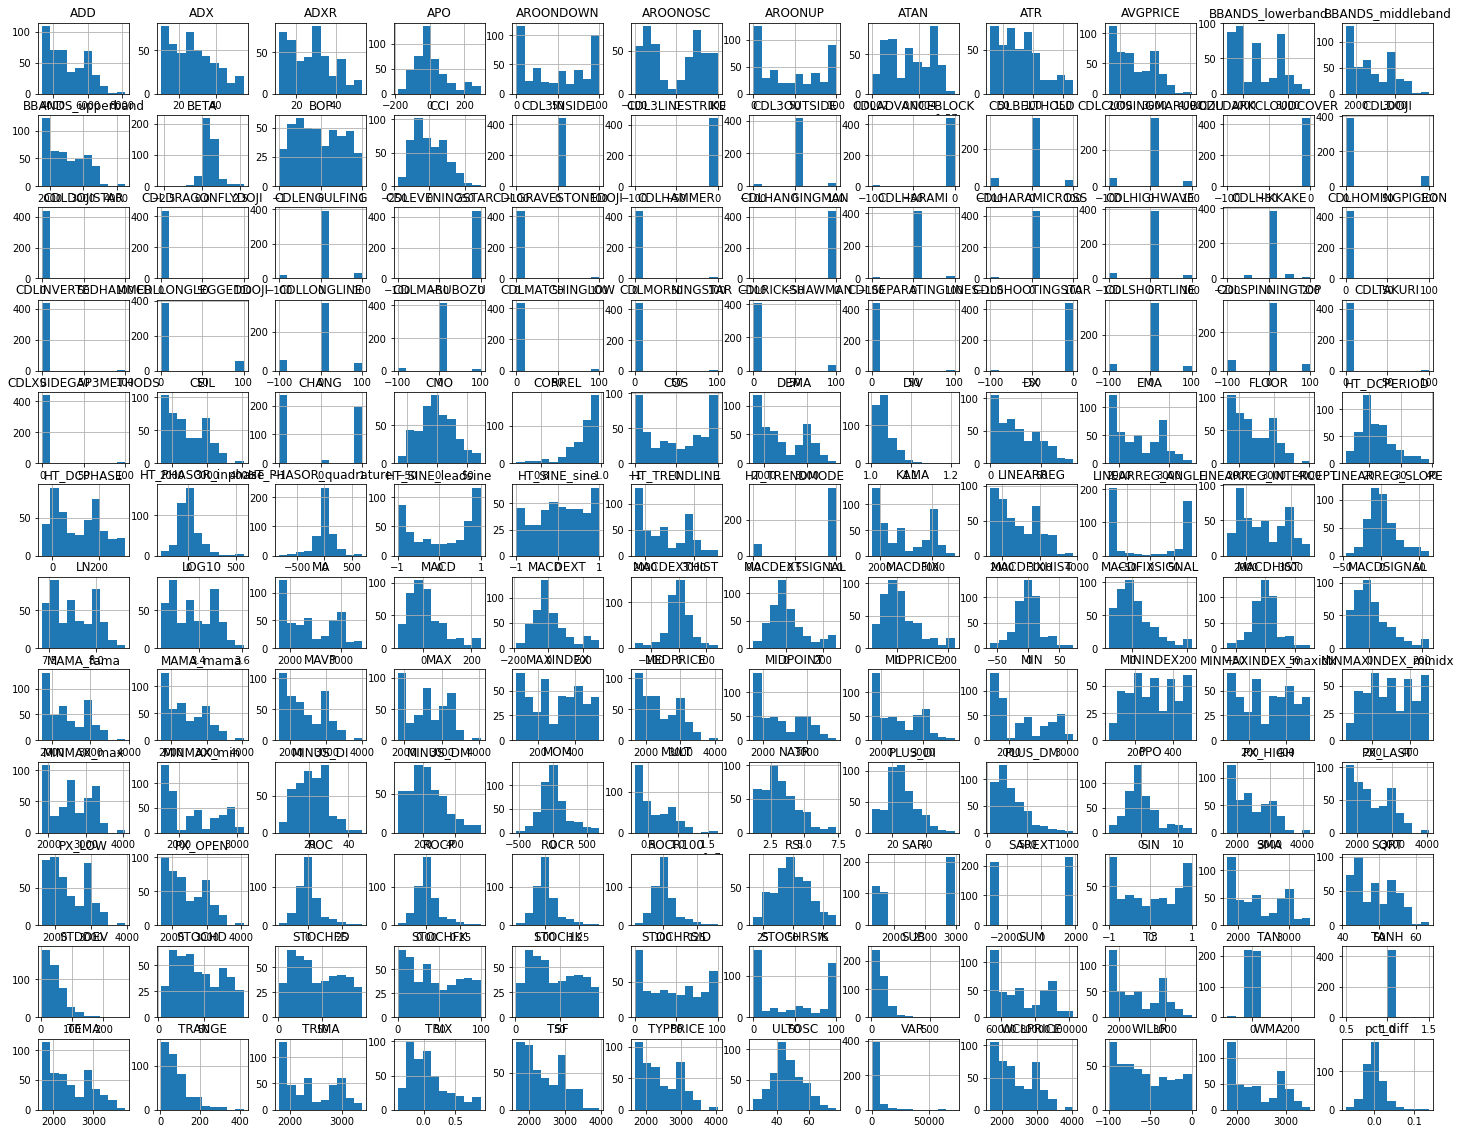

In [19]:
# ----------------------------------------------------------------------------------------------------
# Realizamos una visualizacion de todos los datos a traves de histogramas de frecuencia de los datos
# Esto se realiza para cada columna del conjunto de datos de analisis tecnico, el cual contiene 148 
# columnas 
# ----------------------------------------------------------------------------------------------------

df.hist(figsize=(25, 20))
plt.show()

In [20]:
# ----------------------------------------------------------------------------------------------------
# A continuacion realizamos un analisis descriptivo rapido de las variables, en el cual se presentan
# estadisticos basicos de cada columna
# ----------------------------------------------------------------------------------------------------

df.describe()

,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,ADX,ADXR,APO,AROONDOWN,AROONUP,AROONOSC,BOP,CCI,CMO,DX,MACD,MACDSIGNAL,MACDHIST,MACDEXT,MACDEXTSIGNAL,MACDEXTHIST,MACDFIX,MACDFIXSIGNAL,MACDFIXHIST,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,PPO,ROC,ROCP,ROCR,ROCR100,RSI,STOCHK,STOCHD,STOCHFK,STOCHFD,STOCHRSIK,STOCHRSID,...,MINMAXINDEX_minidx,MINMAXINDEX_maxidx,MULT,SUB,SUM,ATAN,CEIL,COS,FLOOR,LN,LOG10,SIN,SQRT,TAN,TANH,ATR,NATR,TRANGE,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MAMA_mama,MAMA_fama,MAVP,MIDPOINT,MIDPRICE,SAR,SAREXT,SMA,T3,TEMA,TRIMA,WMA,pct_diff,CHANG
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,4.420000e+02,...,442.000000,442.000000,4.420000e+02,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.0,442.000000,442.000000,442.00000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,2410.634819,2408.374729,2454.266109,2369.886086,27.299814,27.570240,9.478123,48.303167,45.248869,-3.054299,-0.030271,-2.587133,-1.165407,26.945189,10.753312,10.895754,-0.142441,9.478123,10.234224,-0.756102,10.241112,10.381864,-0.140752,21.321991,229.565781,15.553778,25.344913,297.509535,0.309574,0.838296,0.008383,1.008383,100.838296,49.417296,44.108125,43.982767,44.225654,44.108125,46.521466,4.638069e+01,...,294.694570,293.579186,6.089243e+06,84.380023,71635.397036,1.570362,2411.067873,0.000986,2410.162896,7.764698,3.372166,0.003350,48.815867,0.223450,1.0,78.958911,3.225304,81.95052,2498.288663,2405.721136,2313.153608,2410.200405,2386.804286,2382.447040,2419.438063,2387.846568,2411.536465,2408.796477,2409.285339,2408.486516,2417.230622,2344.407647,-541.203213,2387.846568,2399.611316,2408.443771,2388.270755,2394.915314,0.000994,-0.092760
std,524.899546,521.573404,540.475589,509.019852,11.689566,10.954453,100.512227,37.618581,37.347564,66.345003,0.545544,110.755207,28.418834,19.788046,72.698078,68.604417,22.101845,100.512227,96.486485,46.998705,69.238847,65.376532,20.979670,7.916631,112.013549,201.647547,8.735292,192.994820,4.260020,8.839450,0.088395,0.088395,8.839450,14.209417,26.108146,24.298423,30.432920,26.108146,42.235606,3.408086e+01,...,123.069747,132.837989,2.677574e+06,64.454580,14014.497627,0.000090,524.925327,0.723410,524.939116,0.213078,0.092538,0.692050,5.263895,20.157424,0.0,34.258428,1.259072,66.40419,546.008228,511.914533,486.367270,526.526303,457.893694,478.544876,477.046197,467.149921,523.444433,511.579194,521.244265,496.258653,496.329040,622.455837,2366.980468,467.149921,495.276205,527.580225,472.705374,481.251593,0.024406,0.984226
min,1679.850000,1674.000000,1716.100000,1637.160000,10.083446,11.176586,-186.164167,0.000000,0.000000,-100.000000,-1.000000,-225.956771,-65.700185,0.177534,-106.417553,-89.238246,-64.229097,-186.164167,-171.905278,-160.507600,-101.098324,-84.908628,-60.604595,4.458843,45.841210,-538.120000,8.158053,38.884934,-8.503831,-21.150022,-0.211500,0.788500,78.849978,17.149907,0.854702,2.804618,0.000000,0.854702,0.000000,-4.736952e-15,...,59.000000,82.000000,2.809530e+06,4.350000,53734.740000,1.570201,1680.000000,-0.999958,1679.000000,7.426460,3.225271,-0.999982,40.985973,-130.121336,1.0,28.769036,1.226537,2.30000,1777.137319,1736.276000,1644.736464,1747.334695,1803.564562,1789.289684,1838.547250,1791.158000,1703.859158,1745.903914,1689.200000,1792.375000,1793.300000,1637.160000,-2980.000000,1791.158000,1783.294370,1715.772756,1793.601792,

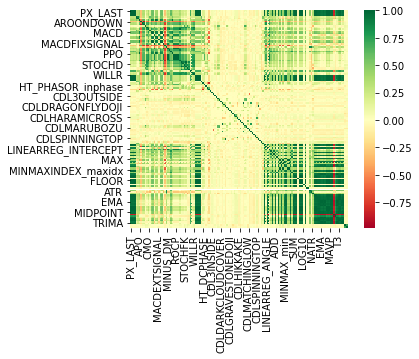

In [21]:
# ----------------------------------------------------------------------------------------------------
# Presentamos matriz de correlacion de manera visual de los datos
# Encontramos unas altas correlaciones pero durante la modelación no se realiza elimnacion de estas 
# variables. Se realizará posteriormente un analisis de reduccion de la dimensionalidad teniendo en 
# cuenta todos los indicadores tecnicos calculados
# ----------------------------------------------------------------------------------------------------
import seaborn as sns
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

A continuacion analizaremos los datos obtenidos del notebook de fundamentales, se seguirá el mismo orden anterior, un historgrama de frecuencia, unos estadisticos y una matriz de correlación

In [22]:
# # Lectura mediante de read excel function de los datos de analisi fundamentales

dfjusto=pd.read_excel(pathDF+Dfjusto)
dfjusto.head(1)

,Fecha,Diferencia sigma,COTREXPM INDEX,COTRIMPM INDEX_x,2331Q001 Index,COEXTOTL INDEX,COEXPUBL INDEX,COEXPRIV INDEX,CORRRMIN INDEX,EHCACO Index,COBPFD INDEX,COBPFP INDEX,EHBBCO Index,COCIPIBQ Index,COCIPIBY Index,GTCOP10Y Govt,COLOM CDS USD SR 5Y D14 Curncy,USDCOP25R1M Curncy,USDCOPV3M Curncy,CESICOP Index,USTBEXP INDEX,USTBIMP INDEX,CONCCONF INDEX,CONSSENT Index,COMFCOMF INDEX,COMFBTWR INDEX,CONSCURR INDEX,CONSEXP INDEX,CONCPSIT INDEX,CONCEXP INDEX,111.044 INDEX,GDP CUR$ Index,USURTOT Index,USHEYOY Index,WDTLUS INDEX,FDTR Index,EHCAUS Index,EHBBUS Index,EMPRGBCI Index,OUTFGAF Index,CHPMINDX Index,CPI CHNG Index,CPUPXCHG Index,CPI YOY Index,CPI XYOY Index,USGG2Y Index,USGG10Y Index,SPX index,FF12 Comdty,USGGT10Y Index,USGGBE05 Index,CESIUSD Index,JFRIUS Index,CTOTUSD Index,MWT VWT Index,KOEXTOT Index,NAPMEXPT Index,CNRSCYOY Index,CNRSACMY Index,CHVAIOY Index,CHVAICY Index,CHLR12MC INDEX,CNCPIMOM Index,CNCPIYOY Index,CNCPCRY Index,CNY Curncy,JPEIGLSP Index,DXY Index,BCOM Index,CESIEM Index,CESICNY Index,JFRIEM Index,JFRICN Index,FARBAST INDEX,EBBSTOTA INDEX,BJACTOTL INDEX,VIX INDEX,CL1 Comdty,GC1 Comdty
0,2006-04-03,-0.050478,1929.86,2154.01,15154,37591,23389,14201,6.0,-0.89,-952.06,685.97,0.13,2.2,6.1,7.895,134.595,0.7272,5.7719,-41.6,118.272,180.846,107.51,88.9,46.0,32.0,109.1,76.0,133.29,90.33,45358,13603.93,4.7,3.6,9942000,4.75,-5.67,-2.33,33.2,14.7,59.3,0.2,0.3,3.4,2.1,4.8414,4.8615,1297.81,94.865,2.3467,2.578,-29.2,101.0,-16.29,93.0,26840.145,57.3,13.5,12.8,17.8,16.7,5.58,-0.9,0.8,0.2,8.0199,191.0,89.63,166.576,-11.5,-54.3,100.5764,106.6,834635,1067.477,144596.6,11.57,66.74,589.4


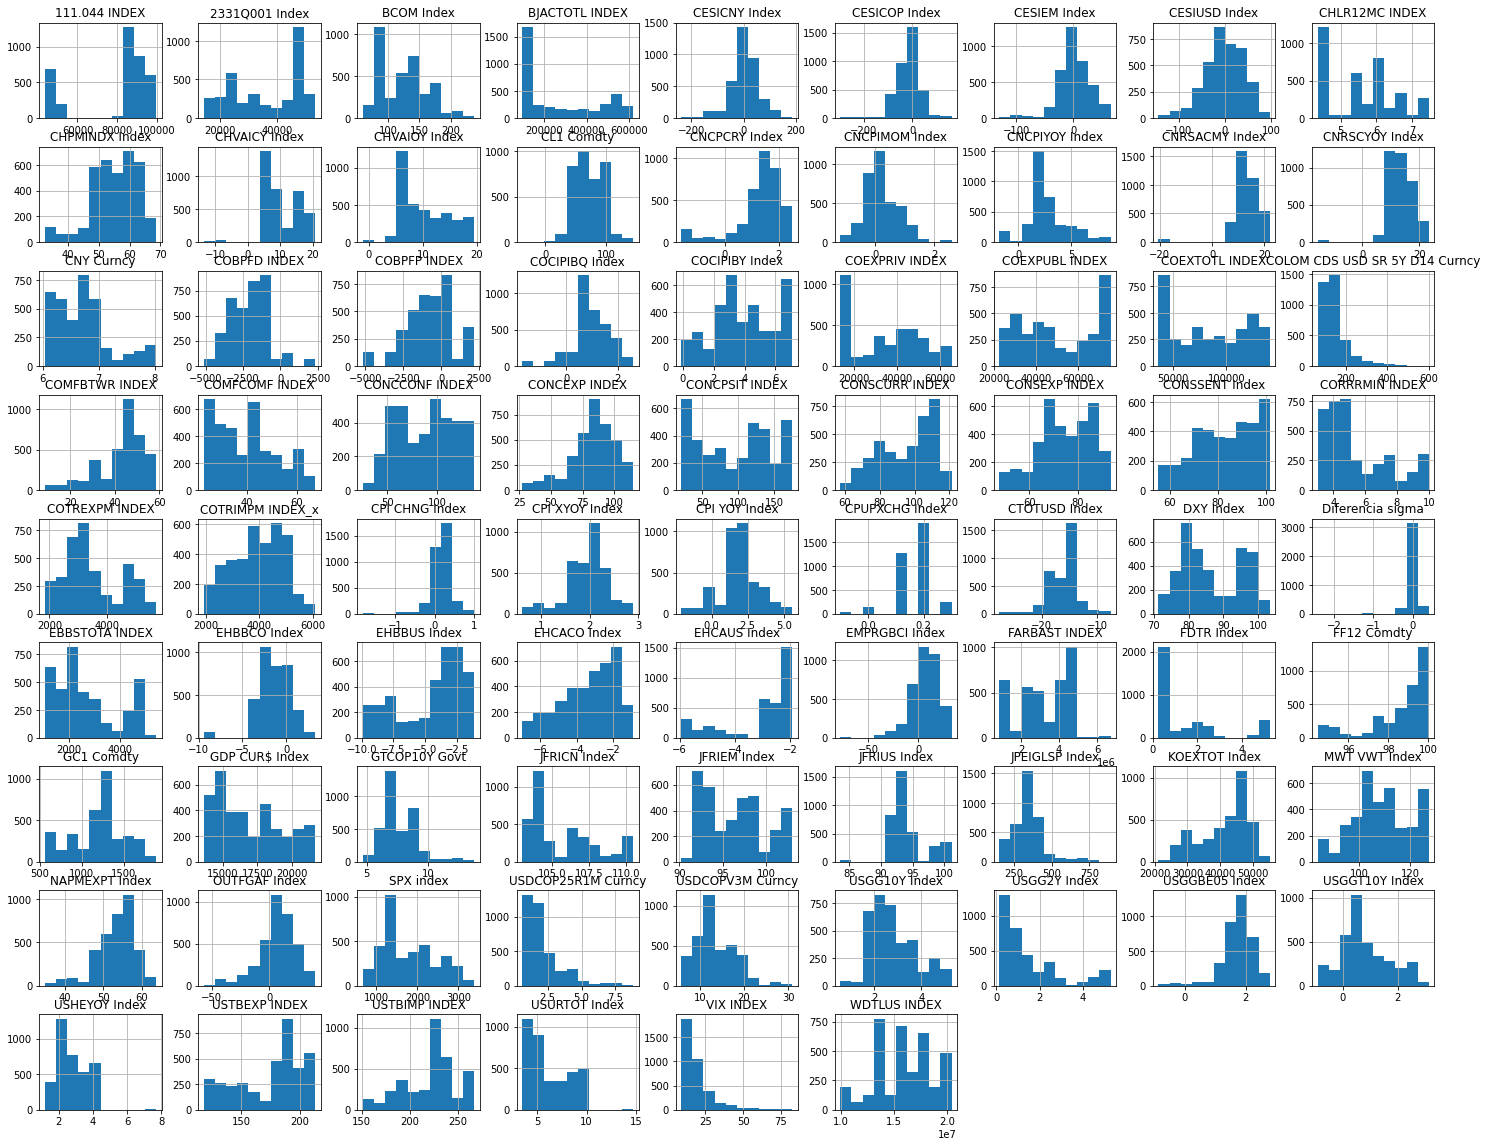

In [23]:
# # Histogramas de frecuencia de los datos de analisis fundamentales
dfjusto.hist(figsize=(25, 20))
plt.show()

In [24]:
# Estadisticos de los datos de analisis fundamentales
dfjusto.describe()

,Diferencia sigma,COTREXPM INDEX,COTRIMPM INDEX_x,2331Q001 Index,COEXTOTL INDEX,COEXPUBL INDEX,COEXPRIV INDEX,CORRRMIN INDEX,EHCACO Index,COBPFD INDEX,COBPFP INDEX,EHBBCO Index,COCIPIBQ Index,COCIPIBY Index,GTCOP10Y Govt,COLOM CDS USD SR 5Y D14 Curncy,USDCOP25R1M Curncy,USDCOPV3M Curncy,CESICOP Index,USTBEXP INDEX,USTBIMP INDEX,CONCCONF INDEX,CONSSENT Index,COMFCOMF INDEX,COMFBTWR INDEX,CONSCURR INDEX,CONSEXP INDEX,CONCPSIT INDEX,CONCEXP INDEX,111.044 INDEX,GDP CUR$ Index,USURTOT Index,USHEYOY Index,WDTLUS INDEX,FDTR Index,EHCAUS Index,EHBBUS Index,EMPRGBCI Index,OUTFGAF Index,CHPMINDX Index,CPI CHNG Index,CPUPXCHG Index,CPI YOY Index,CPI XYOY Index,USGG2Y Index,USGG10Y Index,SPX index,FF12 Comdty,USGGT10Y Index,USGGBE05 Index,CESIUSD Index,JFRIUS Index,CTOTUSD Index,MWT VWT Index,KOEXTOT Index,NAPMEXPT Index,CNRSCYOY Index,CNRSACMY Index,CHVAIOY Index,CHVAICY Index,CHLR12MC INDEX,CNCPIMOM Index,CNCPIYOY Index,CNCPCRY Index,CNY Curncy,JPEIGLSP Index,DXY Index,BCOM Index,CESIEM Index,CESICNY Index,JFRIEM Index,JFRICN Index,FARBAST INDEX,EBBSTOTA INDEX,BJACTOTL INDEX,VIX INDEX,CL1 Comdty,GC1 Comdty
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.00000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.00000,3.644000e+03,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3.644000e+03,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,-0.022528,3476.532873,3945.957936,36108.688529,85685.773875,50393.082327,35292.640231,5.42618,-3.317305,-2035.084871,-768.220568,-1.295285,0.951948,3.941218,7.723163,147.360983,2.146239,13.506972,-15.895554,175.254979,221.903138,88.219673,82.841658,40.055681,42.682217,95.546954,74.675768,95.789007,83.171221,79670.018112,16958.690211,6.176290,2.74528,1.596006e+07,1.337404,-3.064314,-4.506520,6.571789,6.758644,55.082437,0.150768,0.159385,1.931806,1.950823,1.466893,2.798617,1793.813518,98.616198,0.794348,1.740331,-0.992783,94.129463,-16.062901,108.537404,41489.431897,53.293743,13.470143,13.008562,10.245582,10.368222,5.495044,0.220582,2.735675,1.306246,6.727235,345.444103,86.533165,124.324412,1.445664,3.139188,96.463021,105.669656,3.113346e+06,2680.422148,274350.358644,19.262319,72.534311,1209.951015
std,0.206447,968.401085,932.058686,11833.083304,33429.056687,17609.527917,16052.887979,2.04470,1.527359,1262.000666,1591.499830,1.845287,0.744432,1.948428,1.501982,65.415936,1.367583,4.341390,51.529073,27.592795,27.167940,28.745081,12.400796,11.740064,10.437644,15.292129,11.074312,49.973254,17.586692,19304.920019,2401.316142,2.081911,0.82405,2.675232e+06,1.611418,1.223450,2.575515,13.646113,15.398050,7.361740,0.291911,0.073703,1.313801,0.429239,1.381679,0.982681,633.226945,1.490915,0.870978,0.526325,41.518685,2.900286,2.733333,10.954875,7518.035277,4.952481,4.711994,5.257165,4.423235,5.206265,0.966818,0.558407,1.964164,0.840897,0.485211,102.975420,8.412116,37.463182,28.080272,53.322718,3.471274,2.200125,1.346002e+06,1177.535196,176337.309175,9.662484,22.879106,301.158120
min,-2.431439,1843.670000,1933.650000,14462.000000,36907.000000,22550.000000,13590.000000,3.00000,-7.000000,-5113.360000,-5160.580000,-9.390000,-1.700000,-0.100000,4.696000,64.700000,0.615000,5.771900,-297.600000,118.272000,151.593000,25.300000,55.300000,23.000000,8.500000,57.500000,47.600000,20.200000,27.300000,43631.000000,13603.930000,3.500000,

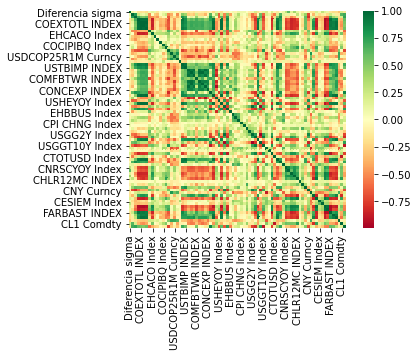

In [25]:
# Matriz de correlacion de los datos de analisis fundamentales

import seaborn as sns
sns.heatmap(dfjusto.corr(), square=True, cmap='RdYlGn')

# 4. Modelación y optimización utilizando machine learning

A continuación se presenta la construcción de procesos de optimización de modelos de machine learning. Para cada modelo de ML, que se presenta a continuacion, se estructuran rangos de valores en los parametros que la funcion original recibe de manera que puedan iterar a traves de un proceso iterativo, el cual arroja como salida final los resultados de la metrica para cada parametro instanciado variando por los dias de agrupamiento, que tambien están en un rango con el fin de encontrar la mejor agrupación - dias agrupado-modelo-parametros del modelo.

Los modelos de clasificacion que se tuvieron en cuenta para esta modelacion son los siguientes:


* Regresión logistica utlizando `LogisticRegression` de `sklearn`
* Bosques Aleatorios utilizado `RandomForestClassifier` de `sklearn`
* Aumento del gradiente `GradientBoostingClassifier` de `sklearn`
* Maquinas de soporte vectorial utilizando `LinearSVC`y `SVC` de `sklearn`

A continuación se realizará la optimización del modelo de Regresión logística

In [84]:
# ----------------------------------------------------------------------------------------------------
# Estas lineas de codigo, utilizan en principio las funciones de lectura y ajuste de los datos que fueron
# explicadas anteriormente. Posteriormente se construye lo que son las variables explicativas o X donde se 
# borran algunas columnas debido a que contienen información que afecta la clasificación o que no sirven para 
# la modelación, estas son 'Dates', 'CHANG' (variable Y), 'pct_diff' (Diferencial de precio). De la misma 
# manera se extrae la columna target y se le asigna a la variable Y. Luego realizamos la partición en train
# y test dejando un 80% para el entrenamiento y un 20% para testear.
# ----------------------------------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression

models_LR=list()
for n in range(10,20):
  df=leer(pathDF,DFname,v_name)
  df=llenarvacios(df,n+1)
  df=bigdata(df)
  df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna().loc[:,(df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna()!=0).any(axis=0)]
  X=np.array(df.drop(['Dates','CHANG','pct_diff'],axis=1))
  y=np.array(df['CHANG'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
  alphas_model = np.logspace(-5, 1, 100)
  train_errors_model = list()
  test_errors_model = list()
# ----------------------------------------------------------------------------------------------------
# Luego de tener la particion del dataset, creamos listas que nos serviran para guardar los resultados
# de las iteraciones de optimización. A continuación realizamos un proceso iterativo donde entrenamos
# el modelo de regresión logistica variando algunos de sus hiperparametros y guardando los resultados 
# de desempeño para posteriormente seleccionar la mejor combinanción. Los hiperparametros que se estan 
# optimizando son el valor del alpha y el valor del l1_ratio (para regularización elasticnet), se utiliza
# regularización elasticnet durante cada entrenamiento de manera que el modelo optimice y seleccione los 
# coeficientes mas importantes para el, adicional a esto, para que sea posible utilizar elasticnet es
# necesario establecer el solver u optimizador del modelo como 'saga'
# ----------------------------------------------------------------------------------------------------
  ratio_model = range(0,101)
  for ratio in ratio_model:
    for alpha in alphas_model:
        model = LogisticRegression(C=alpha, l1_ratio=ratio/100, solver='saga',penalty='elasticnet')
        model.fit(X_train, y_train)
        train_errors_model.append(f1_score(model.predict(X_train), y_train,average='micro'))
        test_errors_model.append(f1_score(model.predict(X_test), y_test,average='micro'))
        models_LR.append(model)
# ----------------------------------------------------------------------------------------------------
# A continuación guardamos los resultados de desempeño utilizando la merica f1_score que se muestra 
# previamente, guardamos tanto para train como para test de cada corrida del modelo y posteriormente
# seleccionamos los valores de los hiperparametros que han dado mejor resultado
# ----------------------------------------------------------------------------------------------------
  best_Md_pos = test_errors_model.index(max(test_errors_model))
  idx_ratio=math.floor(best_Md_pos/len(ratio_model))
  best_ratio_model=ratio_model[idx_ratio]
  idx_alpha=math.floor(best_Md_pos-(idx_ratio)*len(ratio_model))
  best_alpha_model = alphas_model[idx_alpha]
  best_alpha_idx = np.argmax(test_errors_model)
  best_alpha_model = alphas_model[best_alpha_idx]

# ----------------------------------------------------------------------------------------------------
# Una vez obtenidos los mejores valores de los hiperparametros procedemos a realizar el entrenamiento 
# del modelo utilizando esto valores hallados anteriormente e imprimimos los resultados
# ----------------------------------------------------------------------------------------------------

  model = LogisticRegression(C=best_alpha_model, l1_ratio=0, solver='saga',penalty='elasticnet', max_iter=2000) 
  model.fit(X_train, y_train)
  print('Para ' + str(n) + ' dias con ' + str(best_alpha_model) + ' alfa en la ' + str(best_alpha_idx) + 'posición de la lista (base0) y L1_ratio de ' + str(best_ratio_model) +  ' el f1 es:')
  print(f1_score(model.predict(X_train), y_train,average='micro'))
  print(f1_score(model.predict(X_test), y_test,average='micro'))
  print('------------------------------')

Para 10 dias con 1e-05 alfa en la 0posición de la lista (base0) y L1_ratio de 0 el f1 es:
0.5223880597014925
0.5254237288135594
------------------------------
Para 11 dias con 1e-05 alfa en la 0posición de la lista (base0) y L1_ratio de 0 el f1 es:
0.535377358490566
0.4953271028037383
------------------------------
Para 12 dias con 1e-05 alfa en la 0posición de la lista (base0) y L1_ratio de 0 el f1 es:
0.5362694300518135
0.4742268041237113
------------------------------
Para 13 dias con 1e-05 alfa en la 0posición de la lista (base0) y L1_ratio de 0 el f1 es:
0.5325779036827195
0.5168539325842697
------------------------------
Para 14 dias con 1e-05 alfa en la 0posición de la lista (base0) y L1_ratio de 0 el f1 es:
0.5292307692307693
0.5853658536585366
------------------------------
Para 15 dias con 1e-05 alfa en la 0posición de la lista (base0) y L1_ratio de 0 el f1 es:
0.5033333333333333
0.5394736842105263
------------------------------
Para 16 dias con 1e-05 alfa en la 0posición de 

A continuación se realizará la optimización del modelo de Random Forest

In [26]:
# ----------------------------------------------------------------------------------------------------
# Estas lineas de codigo, utilizan en principio las funciones de lectura y ajuste de los datos que fueron
# explicadas anteriormente. Posteriormente se construye lo que son las variables explicativas o X donde se 
# borran algunas columnas debido a que contienen información que afecta la clasificación o que no sirven para 
# la modelación, estas son 'Dates', 'CHANG' (variable Y), 'pct_diff' (Diferencial de precio). De la misma 
# manera se extrae la columna target y se le asigna a la variable Y. Luego realizamos la partición en train
# y test dejando un 80% para el entrenamiento y un 20% para testear.
# ----------------------------------------------------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier

models_rf=list()
for n in range(10,20):
  df=leer(pathDF,DFname,v_name)
  df=llenarvacios(df,n+1)
  df=bigdata(df)
  df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna().loc[:,(df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna()!=0).any(axis=0)] # Esto se hace porque hay columnas completas en 'NAN' o con 'infinito',
  X=np.array(df.drop(['Dates','CHANG','pct_diff'],axis=1))
  y=np.array(df['CHANG'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
# ----------------------------------------------------------------------------------------------------
# Luego de tener la particion del dataset, creamos listas que nos serviran para guardar los resultados
# de las iteraciones de optimización. A continuación realizamos un proceso iterativo donde entrenamos
# el modelo de random forest variando algunos de sus hiperparametros y guardando los resultados 
# de desempeño para posteriormente seleccionar la mejor combinanción. Los hiperparametros que se estan 
# optimizando son el numero de estimadores y la profundidad maxima.
# ----------------------------------------------------------------------------------------------------
  Md_model = range(3,15)
  Ne_model = range(100,320,20)

  train_errors_model = list()
  test_errors_model = list()

  for Ne in Ne_model:

    for Md in Md_model:
        model = RandomForestClassifier(n_estimators=Ne,max_depth=Md)
        model.fit(X_train, y_train)
        train_errors_model.append(f1_score(model.predict(X_train), y_train,average='micro'))
        test_errors_model.append(f1_score(model.predict(X_test), y_test,average='micro'))
        models_rf.append(model)
# ----------------------------------------------------------------------------------------------------
# A continuación guardamos los resultados de desempeño utilizando la merica f1_score que se muestra 
# previamente, guardamos tanto para train como para test de cada corrida del modelo y posteriormente
# seleccionamos los valores de los hiperparametros que han dado mejor resultado
# ----------------------------------------------------------------------------------------------------

  best_Md_pos = test_errors_model.index(max(test_errors_model))
  idx_Ne=math.floor(best_Md_pos/len(Ne_model))
  best_Ne_model=Ne_model[idx_Ne]
  idx_Md=math.floor(best_Md_pos-(idx_Ne)*len(Ne_model))
  best_Md_model = Md_model[idx_Md]
# ----------------------------------------------------------------------------------------------------
# Una vez obtenidos los mejores valores de los hiperparametros procedemos a realizar el entrenamiento 
# del modelo utilizando esto valores hallados anteriormente e imprimimos los resultados
# ----------------------------------------------------------------------------------------------------  
  model = RandomForestClassifier(n_estimators=best_Ne_model,max_depth=best_Md_model)
  model.fit(X_train, y_train)
  print('Para ' + str(n) + ' dias con ' + str(best_Ne_model) + ' estimadores y profundidad maxima de ' + str(best_Md_model) + ' el f1 es:')
  print(f1_score(model.predict(X_train), y_train,average='micro'))
  print(f1_score(model.predict(X_test), y_test,average='micro'))
  print('------------------------------')

Para 10 dias con 220 estimadores y profundidad maxima de 5 el f1 es:
0.8486140724946695
0.5254237288135594
------------------------------
Para 11 dias con 120 estimadores y profundidad maxima de 6 el f1 es:
0.8679245283018869
0.48598130841121495
------------------------------
Para 12 dias con 280 estimadores y profundidad maxima de 13 el f1 es:
1.0
0.41237113402061853
------------------------------
Para 13 dias con 120 estimadores y profundidad maxima de 5 el f1 es:
0.8271954674220963
0.4606741573033708
------------------------------
Para 14 dias con 100 estimadores y profundidad maxima de 12 el f1 es:
1.0
0.5975609756097561
------------------------------
Para 15 dias con 120 estimadores y profundidad maxima de 11 el f1 es:
0.9966666666666667
0.5263157894736842
------------------------------
Para 16 dias con 180 estimadores y profundidad maxima de 10 el f1 es:
0.992831541218638
0.5
------------------------------
Para 17 dias con 180 estimadores y profundidad maxima de 6 el f1 es:
0.915

A continuación se realizará la optimización del modelo de Gradient boosting

In [27]:
# ----------------------------------------------------------------------------------------------------
# Estas lineas de codigo, utilizan en principio las funciones de lectura y ajuste de los datos que fueron
# explicadas anteriormente. Posteriormente se construye lo que son las variables explicativas o X donde se 
# borran algunas columnas debido a que contienen información que afecta la clasificación o que no sirven para 
# la modelación, estas son 'Dates', 'CHANG' (variable Y), 'pct_diff' (Diferencial de precio). De la misma 
# manera se extrae la columna target y se le asigna a la variable Y. Luego realizamos la partición en train
# y test dejando un 80% para el entrenamiento y un 20% para testear.
# ----------------------------------------------------------------------------------------------------

models_gb=list()
for n in range(10,20):
  df=leer(pathDF,DFname,v_name)
  df=llenarvacios(df,n+1)
  df=bigdata(df)
  df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna().loc[:,(df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna()!=0).any(axis=0)] # Esto se hace porque hay columnas completas en 'NAN' o con 'infinito',
  X=np.array(df.drop(['Dates','CHANG','pct_diff'],axis=1))
  y=np.array(df['CHANG'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# ----------------------------------------------------------------------------------------------------
# Luego de tener la particion del dataset, creamos listas que nos serviran para guardar los resultados
# de las iteraciones de optimización. A continuación realizamos un proceso iterativo donde entrenamos
# el modelo de gradient boosting variando algunos de sus hiperparametros y guardando los resultados 
# de desempeño para posteriormente seleccionar la mejor combinanción. Los hiperparametros que se estan 
# optimizando al igual que en el random forest son el numero de estimadores y la profundidad maxima.
# ----------------------------------------------------------------------------------------------------  
  Md_model = range(3,13)
  Ne_model = range(100,320,20)
  train_errors_model = list()
  test_errors_model = list()

  for Ne in Ne_model:

    for Md in Md_model:
        model = GradientBoostingClassifier(n_estimators=Ne,max_depth=Md)
        model.fit(X_train, y_train)
        train_errors_model.append(f1_score(model.predict(X_train), y_train,average='micro'))
        test_errors_model.append(f1_score(model.predict(X_test), y_test,average='micro'))
        models_gb.append(model)
# ----------------------------------------------------------------------------------------------------
# A continuación guardamos los resultados de desempeño utilizando la merica f1_score que se muestra 
# previamente, guardamos tanto para train como para test de cada corrida del modelo y posteriormente
# seleccionamos los valores de los hiperparametros que han dado mejor resultado
# ----------------------------------------------------------------------------------------------------       
  best_Md_pos = test_errors_model.index(max(test_errors_model))
  idx_Ne=math.floor(best_Md_pos/len(Ne_model))
  best_Ne_model=Ne_model[idx_Ne]
  idx_Md=math.floor(best_Md_pos-(idx_Ne)*len(Ne_model))
  best_Md_model = Md_model[idx_Md]

# ----------------------------------------------------------------------------------------------------
# Una vez obtenidos los mejores valores de los hiperparametros procedemos a realizar el entrenamiento 
# del modelo utilizando esto valores hallados anteriormente e imprimimos los resultados
# ----------------------------------------------------------------------------------------------------


  model = GradientBoostingClassifier(n_estimators=best_Ne_model,max_depth=best_Md_model)
  model.fit(X_train, y_train)
  print('Para ' + str(n) + ' dias con ' + str(best_Ne_model) + ' estimadores y profundidad maxima de ' + str(best_Md_model) + ' el f1 es:')
  print(f1_score(model.predict(X_train), y_train,average='micro'))
  print(f1_score(model.predict(X_test), y_test,average='micro'))
  print('------------------------------')

Para 10 dias con 120 estimadores y profundidad maxima de 7 el f1 es:
1.0
0.5169491525423728
------------------------------
Para 11 dias con 140 estimadores y profundidad maxima de 11 el f1 es:
1.0
0.36448598130841114
------------------------------
Para 12 dias con 180 estimadores y profundidad maxima de 5 el f1 es:
1.0
0.4639175257731959
------------------------------
Para 13 dias con 280 estimadores y profundidad maxima de 9 el f1 es:
1.0
0.42696629213483145
------------------------------
Para 14 dias con 100 estimadores y profundidad maxima de 8 el f1 es:
1.0
0.5975609756097561
------------------------------
Para 15 dias con 160 estimadores y profundidad maxima de 7 el f1 es:
1.0
0.4605263157894737
------------------------------
Para 16 dias con 160 estimadores y profundidad maxima de 3 el f1 es:
1.0
0.4714285714285714
------------------------------
Para 17 dias con 200 estimadores y profundidad maxima de 6 el f1 es:
1.0
0.38461538461538464
------------------------------
Para 18 dias

A continuación se realizará la optimización del modelo de maquina de soporte vectorial

In [28]:
# -----------------------------------------------------------------------------------------------------
# Estas lineas de codigo, utilizan en principio las funciones de lectura y ajuste de los datos que fueron
# explicadas anteriormente. Posteriormente se construye lo que son las variables explicativas o X donde se 
# borran algunas columnas debido a que contienen información que afecta la clasificación o que no sirven para 
# la modelación, estas son 'Dates', 'CHANG' (variable Y), 'pct_diff' (Diferencial de precio). De la misma 
# manera se extrae la columna target y se le asigna a la variable Y. Luego realizamos la partición en train
# y test dejando un 80% para el entrenamiento y un 20% para testear.
# -----------------------------------------------------------------------------------------------------
models_lscv=list()
for n in range(10,20):
  df=leer(pathDF,DFname,v_name)
  df=llenarvacios(df,n+1)
  df=bigdata(df)
  df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna().loc[:,(df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna()!=0).any(axis=0)] # Esto se hace porque hay columnas completas en 'NAN' o con 'infinito',
  X=np.array(df.drop(['Dates','CHANG','pct_diff'],axis=1))
  y=np.array(df['CHANG'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# ----------------------------------------------------------------------------------------------------
# Luego de tener la particion del dataset, creamos listas que nos serviran para guardar los resultados
# de las iteraciones de optimización. A continuación realizamos un proceso iterativo donde entrenamos
# el modelo de maquina de soporte vectorial 'LinearSVC' variando algunos de sus hiperparametros y guardando los  
# resultados de desempeño para posteriormente seleccionar la mejor combinanción. Los hiperparametros 
# que se estan  optimizando son el valor del alpha
# ----------------------------------------------------------------------------------------------------

  alphas_model = np.logspace(-5, 1, 100)
  train_errors_model = list()
  test_errors_model = list()

  for alpha in alphas_model:
      model = LinearSVC(C=alpha)
      model.fit(X_train, y_train)
      train_errors_model.append(f1_score(model.predict(X_train), y_train,average='micro'))
      test_errors_model.append(f1_score(model.predict(X_test), y_test,average='micro'))
      models_lscv.append(model)
# ----------------------------------------------------------------------------------------------------
# A continuación guardamos los resultados de desempeño utilizando la merica f1_score que se muestra 
# previamente, guardamos tanto para train como para test de cada corrida del modelo y posteriormente
# seleccionamos los valores de los hiperparametros que han dado mejor resultado
# ----------------------------------------------------------------------------------------------------
  best_alpha_idx = np.argmax(test_errors_model)
  best_alpha_model = alphas_model[best_alpha_idx]


# ----------------------------------------------------------------------------------------------------
# Una vez obtenidos los mejores valores de los hiperparametros procedemos a realizar el entrenamiento 
# del modelo utilizando esto valores hallados anteriormente e imprimimos los resultados
# ----------------------------------------------------------------------------------------------------
  model = LinearSVC(C=best_alpha_model)
  model.fit(X_train, y_train)
  print('Para ' + str(n) + ' dias el f1 es:')
  print(f1_score(model.predict(X_train), y_train,average='micro'))
  print(f1_score(model.predict(X_test), y_test,average='micro'))
  print('------------------------------')

Para 10 dias el f1 es:
0.44136460554371004
0.4491525423728814
------------------------------
Para 11 dias el f1 es:
0.4386792452830189
0.4766355140186916
------------------------------
Para 12 dias el f1 es:
0.4378238341968912
0.4948453608247423
------------------------------
Para 13 dias el f1 es:
0.44192634560906513
0.43820224719101125
------------------------------
Para 14 dias el f1 es:
0.4492307692307692
0.4146341463414634
------------------------------
Para 15 dias el f1 es:
0.4666666666666667
0.4473684210526316
------------------------------
Para 16 dias el f1 es:
0.26881720430107525
0.014285714285714285
------------------------------
Para 17 dias el f1 es:
0.5212355212355212
0.4461538461538462
------------------------------
Para 18 dias el f1 es:
0.5247933884297521
0.4098360655737705
------------------------------
Para 19 dias el f1 es:
0.5132743362831859
0.45614035087719296
------------------------------


A continuación se realizará la optimización del modelo de maquinas de soporte vectorial utilizando `SVC`


In [29]:
# ----------------------------------------------------------------------------------------------------
# Estas lineas de codigo, utilizan en principio las funciones de lectura y ajuste de los datos que fueron
# explicadas anteriormente. Posteriormente se construye lo que son las variables explicativas o X donde se 
# borran algunas columnas debido a que contienen información que afecta la clasificación o que no sirven para 
# la modelación, estas son 'Dates', 'CHANG' (variable Y), 'pct_diff' (Diferencial de precio). De la misma 
# manera se extrae la columna target y se le asigna a la variable Y. Luego realizamos la partición en train
# y test dejando un 80% para el entrenamiento y un 20% para testear.
# ----------------------------------------------------------------------------------------------------
models_psvc=list()
for n in range(10,20):
  df=leer(pathDF,DFname,v_name)
  df=llenarvacios(df,n+1)
  df=bigdata(df)
  df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna().loc[:,(df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna()!=0).any(axis=0)] # Esto se hace porque hay columnas completas en 'NAN' o con 'infinito',
  X=np.array(df.drop(['Dates','CHANG','pct_diff'],axis=1))
  y=np.array(df['CHANG'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# ----------------------------------------------------------------------------------------------------
# Luego de tener la particion del dataset, creamos listas que nos serviran para guardar los resultados
# de las iteraciones de optimización. A continuación realizamos un proceso iterativo donde entrenamos
# el modelo de maquina de soporte vectorial 'SVC' variando algunos de sus hiperparametros y guardando los  
# resultados de desempeño para posteriormente seleccionar la mejor combinanción. Los hiperparametros 
# que se estan  optimizando son el valor del alpha
# ---------------------------------------------------------------------------------------------------- 
  alphas_model = np.logspace(-5, 1, 100)
  train_errors_model = list()
  test_errors_model = list()

  for alpha in alphas_model:
      model = SVC(C=alpha)
      model.fit(X_train, y_train)
      train_errors_model.append(f1_score(model.predict(X_train), y_train,average='micro'))
      test_errors_model.append(f1_score(model.predict(X_test), y_test,average='micro'))
      models_psvc.append(model)
# ----------------------------------------------------------------------------------------------------
# A continuación guardamos los resultados de desempeño utilizando la merica f1_score que se muestra 
# previamente, guardamos tanto para train como para test de cada corrida del modelo y posteriormente
# seleccionamos los valores de los hiperparametros que han dado mejor resultado
# ----------------------------------------------------------------------------------------------------

  best_alpha_idx = np.argmax(test_errors_model)
  best_alpha_model = alphas_model[best_alpha_idx]

# ----------------------------------------------------------------------------------------------------
# Una vez obtenidos los mejores valores de los hiperparametros procedemos a realizar el entrenamiento 
# del modelo utilizando esto valores hallados anteriormente e imprimimos los resultados
# ----------------------------------------------------------------------------------------------------

  model = SVC(C=best_alpha_model)
  model.fit(X_train, y_train)
  print('Para ' + str(n) + ' dias el f1 es:')
  print(f1_score(model.predict(X_train), y_train,average='micro'))
  print(f1_score(model.predict(X_test), y_test,average='micro'))
  print('------------------------------')

Para 10 dias el f1 es:
0.5223880597014925
0.5254237288135594
------------------------------
Para 11 dias el f1 es:
0.535377358490566
0.5233644859813084
------------------------------
Para 12 dias el f1 es:
0.5362694300518135
0.4948453608247423
------------------------------
Para 13 dias el f1 es:
0.5325779036827195
0.5393258426966292
------------------------------
Para 14 dias el f1 es:
0.5292307692307693
0.5853658536585366
------------------------------
Para 15 dias el f1 es:
0.5033333333333333
0.5394736842105263
------------------------------
Para 16 dias el f1 es:
0.5376344086021505
0.5
------------------------------
Para 17 dias el f1 es:
0.5521235521235521
0.46153846153846156
------------------------------
Para 18 dias el f1 es:
0.5247933884297521
0.4098360655737705
------------------------------
Para 19 dias el f1 es:
0.5265486725663717
0.5263157894736842
------------------------------


A continuación se realizará la optimización del modelo de maquinas de soporte vectorial utilizando `SVC`, este codigo optimizará con Kernel rbf


In [48]:
# ----------------------------------------------------------------------------------------------------
# Estas lineas de codigo, utilizan en principio las funciones de lectura y ajuste de los datos que fueron
# explicadas anteriormente. Posteriormente se construye lo que son las variables explicativas o X donde se 
# borran algunas columnas debido a que contienen información que afecta la clasificación o que no sirven para 
# la modelación, estas son 'Dates', 'CHANG' (variable Y), 'pct_diff' (Diferencial de precio). De la misma 
# manera se extrae la columna target y se le asigna a la variable Y. Luego realizamos la partición en train
# y test dejando un 80% para el entrenamiento y un 20% para testear.
# ----------------------------------------------------------------------------------------------------

models_svcg=list()
for n in range(10,20):
  df=leer(pathDF,DFname,v_name)
  df=llenarvacios(df,n+1)
  df=bigdata(df)
  df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna().loc[:,(df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna()!=0).any(axis=0)] # Esto se hace porque hay columnas completas en 'NAN' o con 'infinito',
  X=np.array(df.drop(['Dates','CHANG','pct_diff'],axis=1))
  y=np.array(df['CHANG'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# ----------------------------------------------------------------------------------------------------
# Luego de tener la particion del dataset, creamos listas que nos serviran para guardar los resultados
# de las iteraciones de optimización. A continuación realizamos un proceso iterativo donde entrenamos
# el modelo de maquina de soporte vectorial 'SVC' utilizando kernel rbf variando algunos de sus   
# hiperparametros y guardando los resultados de desempeño para posteriormente seleccionar la mejor  
# combinanción. Los hiperparametros  que se estan  optimizando son el valor del alpha
# ---------------------------------------------------------------------------------------------------- 
  alphas_model = np.logspace(-5, 1, 100)
  train_errors_model = list()
  test_errors_model = list()

  for alpha in alphas_model:
      model = SVC(kernel='rbf',C=alpha)
      model.fit(X_train, y_train)
      train_errors_model.append(f1_score(model.predict(X_train), y_train,average='micro'))
      test_errors_model.append(f1_score(model.predict(X_test), y_test,average='micro'))
      models_svcg.append(model)

# ----------------------------------------------------------------------------------------------------
# A continuación guardamos los resultados de desempeño utilizando la merica f1_score que se muestra 
# previamente, guardamos tanto para train como para test de cada corrida del modelo y posteriormente
# seleccionamos los valores de los hiperparametros que han dado mejor resultado
# ----------------------------------------------------------------------------------------------------

  best_alpha_idx =  np.argmax(test_errors_model)
  best_alpha_model = alphas_model[best_alpha_idx]
# ----------------------------------------------------------------------------------------------------
# Una vez obtenidos los mejores valores de los hiperparametros procedemos a realizar el entrenamiento 
# del modelo utilizando esto valores hallados anteriormente e imprimimos los resultados
# ----------------------------------------------------------------------------------------------------

  model = SVC(kernel='rbf',C=best_alpha_model)
  model.fit(X_train, y_train)
  print('Para ' + str(n) + ' dias el f1 es:')
  print(f1_score(model.predict(X_train), y_train,average='micro'))
  print(f1_score(model.predict(X_test), y_test,average='micro'))
  print('------------------------------')

Para 10 dias el f1 es:
0.5223880597014925
0.5254237288135594
------------------------------
Para 11 dias el f1 es:
0.535377358490566
0.5233644859813084
------------------------------
Para 12 dias el f1 es:
0.5362694300518135
0.4948453608247423
------------------------------
Para 13 dias el f1 es:
0.5325779036827195
0.5393258426966292
------------------------------
Para 14 dias el f1 es:
0.5292307692307693
0.5853658536585366
------------------------------
Para 15 dias el f1 es:
0.5033333333333333
0.5394736842105263
------------------------------
Para 16 dias el f1 es:
0.5376344086021505
0.5
------------------------------
Para 17 dias el f1 es:
0.5521235521235521
0.46153846153846156
------------------------------
Para 18 dias el f1 es:
0.5247933884297521
0.4098360655737705
------------------------------
Para 19 dias el f1 es:
0.5265486725663717
0.5263157894736842
------------------------------


A continuación se realizará la optimización del modelo de maquinas de soporte vectorial utilizando `SVC`, este codigo optimizará con kernel poly


In [49]:
# ----------------------------------------------------------------------------------------------------
# Estas lineas de codigo, utilizan en principio las funciones de lectura y ajuste de los datos que fueron
# explicadas anteriormente. Posteriormente se construye lo que son las variables explicativas o X donde se 
# borran algunas columnas debido a que contienen información que afecta la clasificación o que no sirven para 
# la modelación, estas son 'Dates', 'CHANG' (variable Y), 'pct_diff' (Diferencial de precio). De la misma 
# manera se extrae la columna target y se le asigna a la variable Y. Luego realizamos la partición en train
# y test dejando un 80% para el entrenamiento y un 20% para testear.
# ----------------------------------------------------------------------------------------------------

models_svcp=list()
for n in range(10,20):
  df=leer(pathDF,DFname,v_name)
  df=llenarvacios(df,n+1)
  df=bigdata(df)
  df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna().loc[:,(df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna()!=0).any(axis=0)] # Esto se hace porque hay columnas completas en 'NAN' o con 'infinito',
  X=np.array(df.drop(['Dates','CHANG','pct_diff'],axis=1))
  y=np.array(df['CHANG'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# ----------------------------------------------------------------------------------------------------
# Luego de tener la particion del dataset, creamos listas que nos serviran para guardar los resultados
# de las iteraciones de optimización. A continuación realizamos un proceso iterativo donde entrenamos
# el modelo de maquina de soporte vectorial 'SVC' utilizando kernel poly variando algunos de sus   
# hiperparametros y guardando los resultados de desempeño para posteriormente seleccionar la mejor 
# combinanción. Los hiperparametros que se estan  optimizando son el valor del alpha
# ----------------------------------------------------------------------------------------------------

  alphas_model = np.logspace(-5, 1, 100)
  train_errors_model = list()
  test_errors_model = list()

  for alpha in alphas_model:
      model = SVC(kernel='poly',C=alpha)
      model.fit(X_train, y_train)
      train_errors_model.append(f1_score(model.predict(X_train), y_train,average='micro'))
      test_errors_model.append(f1_score(model.predict(X_test), y_test,average='micro'))
      models_svcp.append(model)
# ----------------------------------------------------------------------------------------------------
# A continuación guardamos los resultados de desempeño utilizando la merica f1_score que se muestra 
# previamente, guardamos tanto para train como para test de cada corrida del modelo y posteriormente
# seleccionamos los valores de los hiperparametros que han dado mejor resultado
# ----------------------------------------------------------------------------------------------------
  best_alpha_idx = np.argmax(test_errors_model)
  best_alpha_model = alphas_model[best_alpha_idx]

# ----------------------------------------------------------------------------------------------------
# Una vez obtenidos los mejores valores de los hiperparametros procedemos a realizar el entrenamiento 
# del modelo utilizando esto valores hallados anteriormente e imprimimos los resultados
# ----------------------------------------------------------------------------------------------------

  model = SVC(kernel='poly',C=best_alpha_model)
  model.fit(X_train, y_train)
  print('Para ' + str(n) + ' dias el f1 es:')
  print(f1_score(model.predict(X_train), y_train,average='micro'))
  print(f1_score(model.predict(X_test), y_test,average='micro'))
  print('------------------------------')

Para 10 dias el f1 es:
0.5223880597014925
0.5254237288135594
------------------------------
Para 11 dias el f1 es:
0.535377358490566
0.5233644859813084
------------------------------
Para 12 dias el f1 es:
0.5362694300518135
0.4948453608247423
------------------------------
Para 13 dias el f1 es:
0.5325779036827195
0.5393258426966292
------------------------------
Para 14 dias el f1 es:
0.5292307692307693
0.5853658536585366
------------------------------
Para 15 dias el f1 es:
0.5033333333333333
0.5394736842105263
------------------------------
Para 16 dias el f1 es:
0.5376344086021505
0.5
------------------------------
Para 17 dias el f1 es:
0.5212355212355212
0.4461538461538462
------------------------------
Para 18 dias el f1 es:
0.5247933884297521
0.4098360655737705
------------------------------
Para 19 dias el f1 es:
0.5132743362831859
0.45614035087719296
------------------------------


# 5. Resultados gráficos e instancia de mejores modelos

**Pendiente guardar nuevos resultados**


In [50]:
# ----------------------------------------------------------------------------------------------------
# Lectura de datos de resultados
# ----------------------------------------------------------------------------------------------------
iters=pd.read_csv('/content/drive/My Drive/PI 2020-1/Datasets/Dataset_Nuevo/Iters.txt',delimiter='\t')
iters.head()

,Dias,Tipo,Gradiient,Gradient_ts,LinearSVC;Plano,LinearSVC;Plano_ts,SVC;Plano,SVC;Plano_ts,SVC;Gaussian,SVC;Gaussian_ts,SVC;Polinomial,SVC;Polinomial_ts
0,0,Train,0.0,0.0,0.389766,0.353709,0.389938,0.359203,0.389938,0.359203,0.389766,0.353709
1,1,Train,0.0,0.0,0.228790,0.209722,0.388039,0.422222,0.388039,0.422222,0.388734,0.363889
2,2,Train,0.0,0.0,0.452482,0.495781,0.450898,0.504219,0.450898,0.504219,0.452482,0.500000
3,3,Train,0.0,0.0,0.464718,0.524217,0.480399,0.464387,0.480399,0.464387,0.469708,0.433048
4,4,Train,0.0,0.0,0.488267,0.490975,0.488267,0.490975,0.488267,0.490975,0.488267,0.490975


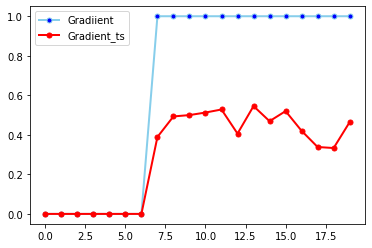

In [51]:
# ----------------------------------------------------------------------------------------------------
# Grafica de XXXXXXX utilizando XXXXXXXXX
# ----------------------------------------------------------------------------------------------------
plt.plot( 'Dias', 'Gradiient', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'Gradient_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=2)
plt.legend()

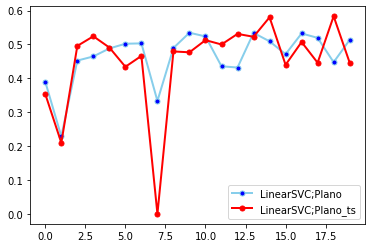

In [52]:
# ----------------------------------------------------------------------------------------------------
# Grafica del desempeño del f1 score del modelo de maquina de soporte vectorial SVC
# ----------------------------------------------------------------------------------------------------
plt.plot( 'Dias', 'LinearSVC;Plano', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'LinearSVC;Plano_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=2)
plt.legend()

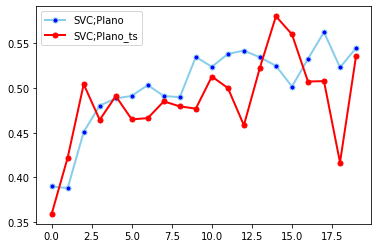

In [0]:
# ----------------------------------------------------------------------------------------------------
# Grafica del desempeño del f1 score del modelo de maquina de soporte vectorial SVC kernel plano
# ----------------------------------------------------------------------------------------------------
plt.plot( 'Dias', 'SVC;Plano', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'SVC;Plano_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=2)
plt.legend()

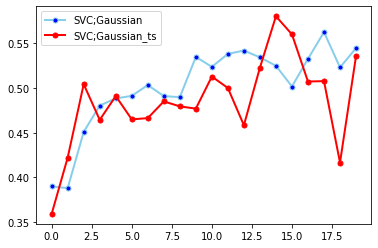

In [0]:
# ----------------------------------------------------------------------------------------------------
# Grafica del desempeño del f1 score del modelo de maquina de soporte vectorial SVC kernel gaussian
# ----------------------------------------------------------------------------------------------------
plt.plot( 'Dias', 'SVC;Gaussian', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'SVC;Gaussian_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=2)
plt.legend()

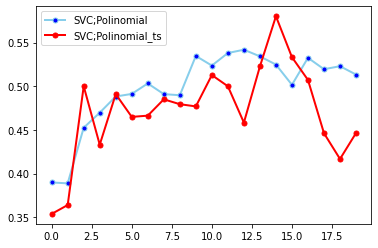

In [0]:
# ----------------------------------------------------------------------------------------------------
# Grafica del desempeño del f1 score del modelo de maquina de soporte vectorial SVC kernel polinomio
# ----------------------------------------------------------------------------------------------------
plt.plot( 'Dias', 'SVC;Polinomial', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'SVC;Polinomial_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=2)
plt.legend()

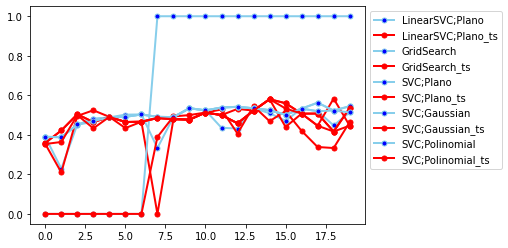

In [0]:
# ----------------------------------------------------------------------------------------------------
# Grafica del desempeño del f1 score de los modelos propuestos
# ----------------------------------------------------------------------------------------------------

plt.plot( 'Dias', 'LinearSVC;Plano', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'LinearSVC;Plano_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=2)
plt.plot( 'Dias', 'GridSearch', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'GridSearch_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=2)
plt.plot( 'Dias', 'SVC;Plano', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'SVC;Plano_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=2)
plt.plot( 'Dias', 'SVC;Gaussian', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'SVC;Gaussian_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=2)
plt.plot( 'Dias', 'SVC;Polinomial', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'SVC;Polinomial_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='red', linewidth=2)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

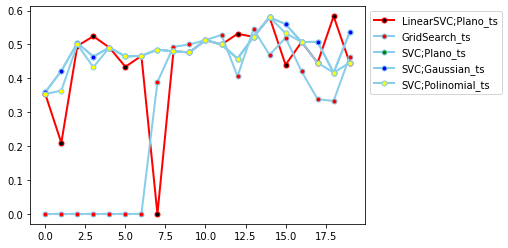

In [0]:
plt.plot( 'Dias', 'LinearSVC;Plano_ts', data=iters, marker='o', markerfacecolor='black', markersize=5, color='red', linewidth=2)
plt.plot( 'Dias', 'GridSearch_ts', data=iters, marker='o', markerfacecolor='red', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'SVC;Plano_ts', data=iters, marker='o', markerfacecolor='green', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'SVC;Gaussian_ts', data=iters, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2)
plt.plot( 'Dias', 'SVC;Polinomial_ts', data=iters, marker='o', markerfacecolor='yellow', markersize=5, color='skyblue', linewidth=2)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

In [0]:
#df.to_excel('/content/drive/My Drive/PI 2020-1/Datasets/BigData Fx.xlsx')

Instanciamos el modelo que mejor resultado obtuvo con sus hiperparametros durantes el proceso de optimización. Este es el Gradient Boosting con 200 estimadores y profundidad de 12

In [48]:
best_model = GradientBoostingClassifier(n_estimators=280,max_depth=12)
best_model.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=12,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=280,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# 6. Reducción de la dimensionalidad y entrenamiento con mejor modelo

In [0]:
# -------------------------------------------------------------------------------------
# Realizamos lectura de los datos con ventana de datos personalizada acorde a los
# hallazgos encontrados. Para este caso realizamos un merge entre los datos calculados
# en el análisis tecnico y el analsis fundamental, utilizando de este ultimo las variaciones
# del valor encontrado en el mejor modelo de regresion vs el valor del activo
# -------------------------------------------------------------------------------------

df=leer(pathDF,DFname,v_name)
dfjusto=pd.read_excel(pathDF+Dfjusto)
df=llenarvacios(df,14)

df2=dfjusto[['Diferencia sigma','Fecha']]
df = pd.merge(df,df2,left_on='Dates',right_on='Fecha')

df=bigdata(df)
df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna().loc[:,(df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,how='all').dropna()!=0).any(axis=0)]
df=df.drop('Fecha',axis=1)
X=np.array(df.drop(['Dates','CHANG','pct_diff', 'PX_HIGH',	'PX_LOW'],axis=1))
y=np.array(df['CHANG'])

In [0]:
# Definición de conjuntos de entrenamiento y prueba

X=df.set_index('Dates')
X=X.drop(['pct_diff', 'PX_HIGH',	'PX_LOW'],axis=1)

train = X.loc['2001-03-18':'2017-12-31'] 
test = X.loc['2018-01-01':'2020-02-29'] 
 
X_train = train.drop('CHANG',axis=1)
y_train = train['CHANG']
 
X_test = test.drop('CHANG',axis=1)
y_test = test['CHANG']

## Reducción de dimesionalidad utilizando LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
#-------------------------------------------------------------------------------
# Realizamos una estandarización empleando StandarScaler 
#-------------------------------------------------------------------------------
x_scaler = StandardScaler().fit(X_train)
x = pd.DataFrame(x_scaler.transform(X_train))


In [0]:
#-------------------------------------------------------------------------------
# Instanciamos el modelo de reducción utilizando dos componentes y posteriormente
# realizamos el entrenamiento de los datos
#-------------------------------------------------------------------------------
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(x, y_train).transform(x)

In [45]:
from sklearn.metrics import accuracy_score

accuracy_model=[]
model=GradientBoostingClassifier(n_estimators=180,max_depth=3,random_state=42) 
model.fit(X_r2,y_train)

transformed_test = x_scaler.transform(X_test)
transformed_test = lda.transform(transformed_test)

accuracy_model.append(accuracy_score(y_test, model.predict(transformed_test), normalize=True)*100)
print(accuracy_model)

[55.172413793103445]


In [46]:
print(confusion_matrix(y_test,model.predict(transformed_test)))
print(classification_report(y_test,model.predict(transformed_test)))

[[11  2 15]
 [ 0  0  1]
 [ 8  0 21]]
              precision    recall  f1-score   support

          -1       0.58      0.39      0.47        28
           0       0.00      0.00      0.00         1
           1       0.57      0.72      0.64        29

    accuracy                           0.55        58
   macro avg       0.38      0.37      0.37        58
weighted avg       0.56      0.55      0.54        58



# 7. Backtesnting simple


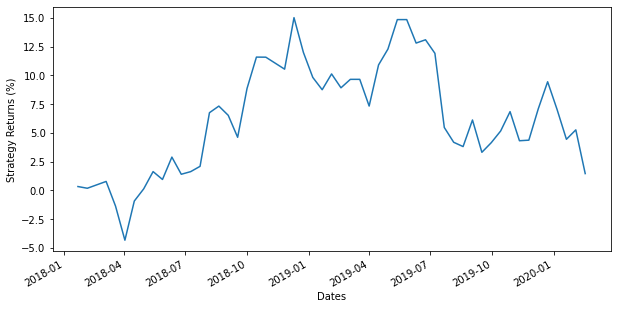

In [41]:
#------------------------------------------------------------------------
# Graficamos la rentabilidad en el periodo de testeo teniendo en cuenta
# la recomendacion que dio el modelo sobre compra o venta. El periodo de test
# va desde 2018-01-01 hasta 2020-02-29. Antes que comenzara el tema del
# corona virus 
#------------------------------------------------------------------------

X_transformed = x_scaler.transform(X_test)
X_transformed = lda.transform(X_transformed)

X_test['Predicted_Signal'] = model.predict(X_transformed)

X_test['Return'] = np.log(X_test.PX_LAST / X_test.PX_LAST.shift(1))*100
X_test['Strategy_Return'] = X_test.Return * X_test.Predicted_Signal
X_test.Strategy_Return.cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

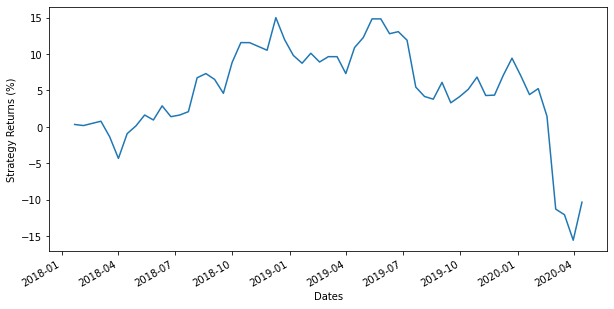

In [47]:
#------------------------------------------------------------------------
# Graficamos la rentabilidad en el periodo de testeo teniendo en cuenta
# la recomendacion que dio el modelo sobre compra o venta. El periodo de test
# va desde 2018-01-01 hasta 2020-05-29. Aqui observamos que pasa con el modelo
# con la llegada del corona virus 
#------------------------------------------------------------------------


X_transformed = x_scaler.transform(X_test)
X_transformed = lda.transform(X_transformed)

X_test['Predicted_Signal'] = model.predict(X_transformed)

X_test['Return'] = np.log(X_test.PX_LAST / X_test.PX_LAST.shift(1))*100
X_test['Strategy_Return'] = X_test.Return * X_test.Predicted_Signal
X_test.Strategy_Return.cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()